In [724]:
%matplotlib inline
import csv
import statistics
import scipy
from scipy import optimize
from scipy.stats import circmean
from scipy.spatial.distance import cdist
import math
import pandas as pd
from tabulate import tabulate
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Data processing

In [725]:
def bangle(file): 
    res = pd.read_csv(file, sep=',',names=['loggingTime','accelerometerAccelerationX','accelerometerAccelerationY','accelerometerAccelerationZ','accelerometerDiff','accelerometerMag','locationLatitude','locationLongitude','locationAltitude','gpstime','locationTrueHeading'])
    res = res.drop(['gpstime'], axis =1)
    return res

def iphone_imu_read(file):
    res = pd.read_csv(file, sep=',')
    res = res.drop(['loggingSample','identifierForVendor','locationTimestamp_since1970','locationSpeed','locationCourse','locationVerticalAccuracy','locationHorizontalAccuracy','locationFloor','locationHeadingTimestamp_since1970','accelerometerTimestamp_sinceReboot','gyroTimestamp_sinceReboot','magnetometerTimestamp_sinceReboot','motionTimestamp_sinceReboot','motionAttitudeReferenceFrame','motionMagneticFieldCalibrationAccuracy','pedometerStartDate','pedometerNumberofSteps','pedometerAverageActivePace','pedometerCurrentPace','pedometerCurrentCadence','pedometerDistance','pedometerFloorAscended','pedometerFloorDescended','pedometerEndDate','altimeterTimestamp_sinceReboot','altimeterReset','altimeterRelativeAltitude','altimeterPressure','deviceOrientation','locationHeadingX','locationHeadingY','locationHeadingZ','motionMagneticFieldX','motionMagneticFieldY','motionMagneticFieldZ'],axis=1)
    return res

def iphone_camera_read(file):
    res = pd.read_csv(file, sep=',')
    for column in res:
        res['data'] = res[column]
    res['timestamp'],res['r11'],res['r12'],res['r13'],res['positionX'],res['r21'],res['r22'],res['r23'],res['positionY'],res['r31'],res['r32'],res['r33'],res['positionZ'],res['empty'] = res['data'].str.split(' ').str
    res = res.drop([column,'data','empty'],axis=1)
    for column in res:
        res[column] = pd.to_numeric(res[column],errors='coerce')
    return res

def intel_read(file):
    res = pd.read_csv(file, sep=',')
    res['positionX'], res['positionY'], res['positionZ'] = res['position'].str.split(',').str
    res['velocityX'], res['velocityY'], res['velocityZ'] = res['velocity'].str.split(',').str 
    res['accelerationX'], res['accelerationY'], res['accelerationZ'] = res['acceleration'].str.split(',').str 
    res = res.drop(['acceleration','velocity','position'],axis=1)
    res['time'] = pd.to_datetime(res['time'], format="%Y-%m-%d %H:%M:%S")
    res['timestamp'] = res['time'].values.astype(np.int64) // 10 ** 6
    for column in res:
        if res[column].dtype == object:
            res[column] = res[column].str.replace('x:','')
            res[column] = res[column].str.replace('y:','')
            res[column] = res[column].str.replace('z:','')
            res[column] = pd.to_numeric(res[column],errors='coerce')
    return res

def normalise(data, avgs):
    result = []
    for i, row in enumerate(data):
        if i >= avgs-1 and i%avgs == 0:
            line = {}
            for key in row.keys():
                if key != 'locationTrueHeading' and key != 'locationMagneticHeading':
                    j = i - (avgs-1)
                    val = 0
                    while j <= i:
                        val = val + data[j][key]
                        j = j + 1
                    val = val/avgs
                    line[key] = val
                else:
                    j = i - (avgs-1)
                    val = []
                    while j <= i:
                        val.append(data[j][key])
                        j = j + 1
                    res = circmean(val, high=360,low=0)
                    line[key] = res
            result.append(line)
    return result
        
            
        
# pandas version - > data.groupby(np.arange(len(data))//rows).mean()
    

### Experimentation ideal path 

Experiment 1: 

Details: 
     - Fairly open space (pictures in notion)
     - 30m by 8m Rectangular walk.
     - Time taken was about 55 seconds.
     - Initial heading at 270 degrees. 
     - Ground truth measurements accounted for every 2m -> total of 38 measurements. 


In [613]:
experiment1GT = []
x = 0 
y = 0 
z = 0 
i = 0 
while i < 39:
    experiment1GT.append({'positionX':x,'positionY':y,'positionZ':z})
    if i < 15:
        x = x + 2
    if i >= 15 and i < 19:
        z = z + 2 
    if i >= 19 and i < 34:
        x = x-2
    if i >= 34 and i < 38:
        z = z - 2
    i = i + 1

exp1GT = pd.DataFrame(experiment1GT)


### Errors

In [614]:
def error(gt, res):
    error = []
    for index, row in gt.iterrows():
        gtarray = np.array([(row['positionX'],row['positionY'],row['positionZ'])])
        resarray = []
        for index, msmt in res.iterrows():
            resarray.append((msmt['positionX'],msmt['positionY'],msmt['positionZ']))
        resarray = np.array(resarray)
        err = np.min(cdist(gtarray, resarray, 'euclidean'))
        error.append(err)
    result = {'mean':sum(error)/len(error),'peak':max(error),'stdev':statistics.stdev(error)}
    return result 

### Bangle.js 

In [615]:
bangle_rd = bangle('IMU/bangle/indoorlog.csv')
print(bangle_rd[0:2])

   loggingTime  accelerometerAccelerationX  accelerometerAccelerationY  \
0   1597202006                   -0.088623                   -0.934937   
1   1597202006                   -0.007568                   -0.944824   

   accelerometerAccelerationZ  accelerometerDiff  accelerometerMag  \
0                   -0.314453           0.078393          0.990374   
1                   -0.287964           0.085845          0.987762   

   locationLatitude  locationLongitude  locationAltitude  locationTrueHeading  
0               NaN                NaN               NaN              28.4429  
1               NaN                NaN               NaN              24.7751  


### Apple IMU 

In [616]:
iphone_rd=iphone_imu_read('IMU/iphone/indoorlog.csv')
iphone_square = iphone_imu_read('IMU/iphone/Chest1.csv')
print(iphone_rd[0:2])

    loggingTime  locationLatitude  locationLongitude  locationAltitude  \
0  1.597209e+09          1.296991         103.894673          35.71167   
1  1.597209e+09          1.296991         103.894673          35.71167   

   locationTrueHeading  locationMagneticHeading  locationHeadingAccuracy  \
0           178.986923               178.846054                16.235439   
1           178.986923               178.846054                16.235439   

   accelerometerAccelerationX  accelerometerAccelerationY  \
0                    0.106659                    0.981125   
1                    0.119308                    0.989319   

   accelerometerAccelerationZ  ...  motionUserAccelerationX  \
0                   -0.063385  ...                -0.009505   
1                   -0.067734  ...                -0.010086   

   motionUserAccelerationY  motionUserAccelerationZ  motionQuaternionX  \
0                -0.017822                -0.008527          -0.149157   
1                -0.004998

### IMU algorithms


In [716]:
def dataFiltering1(data, NoOfValuesToAverageOver):
    data['acc'] = np.sqrt(data['accelerometerAccelerationX']*data['accelerometerAccelerationX']+data['accelerometerAccelerationY']*data['accelerometerAccelerationY']+data['accelerometerAccelerationZ']*data['accelerometerAccelerationZ'])
    ld = data.T.to_dict()
    data = []
    for row in ld.values():
        data.append(row)
    data = normalise(data, NoOfValuesToAverageOver)
    return data

def dataFiltering2(data, NoOfValuesToAverageOver):
    ld = data.T.to_dict()
    data = []
    for row in ld.values():
        data.append(row)
        
    #comverting coordinate systems 
    for i,row in enumerate(data):
        yaw = row['motionRotationRateZ']
        pitch = row['motionRotationRateY']
        roll = row['motionRotationRateX']
        Rt1 = [math.cos(yaw)*math.cos(roll)-math.sin(yaw)*math.sin(pitch)*math.sin(roll), -math.sin(yaw)*math.cos(pitch), math.cos(yaw)*math.sin(roll)+math.sin(yaw)*math.sin(pitch)*math.cos(roll)]
        Rt2 = [-math.sin(yaw)*math.cos(roll)-math.cos(yaw)*math.sin(pitch)*math.sin(roll), -math.cos(yaw)*math.cos(pitch), -math.sin(yaw)*math.sin(roll)+math.cos(yaw)*math.sin(pitch)*math.cos(roll)]
        Rt3 = [-math.cos(pitch)*math.sin(roll),math.sin(pitch),math.cos(pitch)*math.cos(roll)]
        Rt = [Rt1, Rt2, Rt3]
        Alcs = [row['accelerometerAccelerationX'],row['accelerometerAccelerationY'],row['accelerometerAccelerationZ']]
        
        x = np.matmul(Rt, Alcs)
        data[i]['agcsx'] = x[0]
        data[i]['agcsy'] = x[1]
        data[i]['agcsz'] = x[2]
        
        if i == 0:
            data[i]['g'] = 1
        else:
            data[i]['g'] = data[i-1]['g']*0.90 + 0.1*data[i]['agcsz']
            data[i]['ahpf'] = data[i]['agcsx'] - data[i]['g']
        
        Mlcs = [row['magnetometerX'],row['magnetometerY'],row['magnetometerZ']]
        m = np.matmul(Rt, Mlcs)
        data[i]['mgcsx'] = m[0]
        data[i]['mgcsy'] = m[1]
        data[i]['mgcsz'] = m[2]
        
        data[i]['magheading'] = np.arctan2(-m[1],m[0]) + 0.14
        
        g = [0,0,data[i]['motionGravityZ']]
        Rtt = np.transpose(Rt)
        gt = np.matmul(Rtt, g)
        wt = [pitch,roll,yaw]
        data[i]['wgcs'] = np.matmul(wt, gt)/(np.linalg.norm(gt))
        start = i
        integratedgyro = 0
        while start >= 0:
            integratedgyro = integratedgyro-data[start]['wgcs']
            start = start - 1
        data[i]['gyroheading'] = math.degrees(integratedgyro) % 360

    data = normalise(data, NoOfValuesToAverageOver)
    
#     #graphing for testing
#     datapd = pd.DataFrame(data)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.scatter(datapd['loggingTime'],datapd['ahpf'])
#     plt.plot(datapd['loggingTime'],datapd['ahpf'])
#     plt.show()
    
    return data


In [717]:
def stepDetection1(data):
    msum = 0
    for row in data:
        msum = row['acc'] + msum
    mean = msum/len(data)
    current = data[0]['acc']
    lengths = []
    rows = []
    maxi = 0
    mini = 10000
    for i, row in enumerate(data):
        if row['acc'] > maxi:
            maxi = row['acc']
        if row['acc'] < mini:
            mini = row['acc']
        if (row['acc'] < mean and current > mean) or (row['acc'] < mean and current < mean):
            rows.append(i)
            length = 1.4*((maxi-mini)**(1/4))
            lengths.append(length)
    return lengths, rows

def stepDetection2(data):
    peaks = []
    pps = []
    valleys = []
    lengths = []
    for i, row in enumerate(data):
        mx = 0 
        if row['ahpf'] > 0.25 and row['ahpf'] > mx:
            mx = row['ahpf']
            if i < len(data)-1:
                if row['ahpf'] > data[i+1]['ahpf']:
                    peaks.append(i)
                    mx = 0 
    for j in peaks:
        mn = 100
        k = 1 
        valley = 0
        while k < 4 and  (j+k) < len(data) and data[j+k]['ahpf'] < data[j]['ahpf']:
            if data[j+k]['ahpf'] < mn:
                mn = data[j+k]['ahpf']
            k = k + 1
        if data[j]['ahpf'] - mn > 0.30:
            valley = valley + 1
            
        mn = 100
        mnindex = -1
        k = 1 
        while k < 4 and (j-k) > 0 and data[j-k]['ahpf'] < data[j]['ahpf']:
            if data[j-k]['ahpf'] < mn:
                mn = data[j-k]['ahpf']
                mnindex = j-k
            k = k + 1
        if data[j]['ahpf'] - mn > 0.30:
            valley = valley + 1
            diff = data[j]['ahpf'] - mn
        
        if valley == 2:
            pps.append(j)
            valleys.append(mnindex)
            diff = 2.55*(diff**(1/4))
            lengths.append(diff)
            
    return lengths, pps, valleys

In [718]:
def headings1(data, rows):
    headings = []
    for x in rows:
        headings.append(data[x]['locationTrueHeading'])
    headingsdiff = 90 - (headings[0]%90)
    for i, item in enumerate(headings):
        headings[i] = headings[i] + headingsdiff
    return headings

def headings2(data, valleys):
    headings = []
    for i, row in enumerate(data):
        if i == 0:
            wprev = 0
            wprevmag = row['magheading']
        else:
            wprev = data[i-1]['chosenheading']
            wprevmag = data[i-1]['magheading']
        wmag = row['magheading']
        wgyro = row['gyroheading']
        hmag = abs(wmag - wprevmag)
        hcor = abs(wmag - wgyro)
        wpmg = 1/5
        wmg = 1/3
        wpg = 1/4
        if hcor <= 5 and hmag <= 2:
            data[i]['chosenheading'] = wpmg*(2*wprev+1*wmag+2*wgyro)
        if hcor <= 5 and hmag > 2:
            data[i]['chosenheading'] = wmg*(1*wmag+2*wgyro)
        if hcor > 5 and hmag <= 2:
            data[i]['chosenheading'] = wprev
        if hcor > 5 and hmag > 2:
            data[i]['chosenheading'] = wpg*(2*wprev+2*wgyro)
    for j in valleys:
        headings.append(data[j]['chosenheading'])
    return valleys

In [719]:
def deadReckoning1(lengths, headings, xcor, ycor, zcor):
    x, y, z = [0],[0],[0]
    
    for i, lgth in enumerate(lengths):
        tx,tz,ty = x[i]+xcor,z[i]+zcor,y[i]+ycor
        x.append(tx+(lgth * math.cos(headings[i]*(math.pi/180))))
        z.append(tz+(-1 * lgth * math.sin(headings[i]*(math.pi/180))))
        y.append(ty)
    return x, y, z

# correcting values based on known checkpoints
def checkpointing(pos, exppos, lgth):
    xdiff = 0 
    ydiff = 0 
    zdiff = 0 
    for i, p in enumerate(pos):
        xdiff = xdiff + p['x'] - exppos[i]['x']
        ydiff = ydiff + p['y'] - exppos[i]['y']
        zdiff = zdiff + p['z'] - exppos[i]['z']
    xdiff = (xdiff/len(pos))/lgth
    ydiff = (ydiff/len(pos))/lgth
    zdiff = (zdiff/len(pos))/lgth
    return xdiff, ydiff, zdiff
        
    

In [720]:
def visualisation(a,b,c):
    
    fig3d = plt.figure()
    ax3d = plt.axes(projection='3d')
    ax3d.scatter3D(a,b,c)
    
    h = []
    l = []
    for i, ax in enumerate(a):
        h.append(np.arctan2(b[i], ax))
        l.append(np.sqrt(ax**2 + b[i]**2))
    
    figpolar = plt.figure()
    ax = figpolar.add_subplot(111, projection='polar')
    ax.scatter(h, l)
    
    #     fig = plt.figure()
    #     ax = plt.axes()
    #     ax.scatter(a,b)
    #     ax.scatter(b,c)
    
    # Graphs to understand accelerometer data    
    #     data = pd.DataFrame(data)
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111)
    #     ax.scatter(data['loggingTime'],data['acc'])
    #     plt.plot(data['loggingTime'],data['acc'])
    #     plt.show()

    # Tried to do a polar plot, realised it doesn't really work
    #     ax = fig.add_subplot(111, projection='polar')
    #     ax.scatter(headings, lengths)


    # Tried to see if plotting it like a sin wave would be helpful. Clearly not. 
    #     def test_func(x, a, b):
    #         return a * np.sin(b * x)
    #     params, params_covariance = optimize.curve_fit(test_func, data['loggingTime'], data['acc'],
    #                                                    p0=[5, 5])
    #     plt.plot(data['loggingTime'], test_func(data['loggingTime'], params[0], params[1]),
    #              label='Fitted function')
    #     print(params)


In [729]:
def algorithm1(data):
    data = dataFiltering1(data, 4)
    lengths, rows = stepDetection1(data)
    headings = headings1(data, rows)
    x, y, z = deadReckoning1(lengths, headings, 0, 0, 0)
    visualisation(x, z, y)

def algorithm2(data):
    data = dataFiltering2(data, 2)
    lengths, rows, valleys = stepDetection2(data)
    headings = headings1(data, rows) # headings 2 doesnt seem work very well - whats wrong with the gyro??
    x, y, z = deadReckoning1(lengths, headings, 0, 0, 0)
    end = len(x)-1
    startpoint = {'x':x[0],'y':y[0],'z':z[0]}
    endpoint = {'x':x[end],'y':y[end],'z':z[end]}
    xd, yd, zd = checkpointing([startpoint],[endpoint], len(x))
    x, y, z = deadReckoning1(lengths, headings, xd, yd, zd)
    visualisation(x, z, y)
    return error(exp1GT, pd.DataFrame({'positionX':z,'positionY':y,'positionZ':x}))
    
# algorithm1(iphone_rd)
# algorithm2(iphone_rd)
#algorithm1(iphone_square)
#algorithm2(iphone_square)

{'mean': 3.0966359515648487, 'peak': 7.48762257335889, 'stdev': 2.7834618225741954}
{'mean': 14.982891119676607, 'peak': 30.67067153738007, 'stdev': 10.480895889053023}
{'mean': 1.318239456366736, 'peak': 2.726040322523945, 'stdev': 0.6685807752322338}
{'mean': 1.2527711897868794, 'peak': 4.318533859012187, 'stdev': 1.2482720642192315}
{'mean': 1.8390189545796347, 'peak': 3.505066919778034, 'stdev': 1.2258240883657738}
{'mean': 14.826081861889492, 'peak': 30.587851702160197, 'stdev': 10.53821243120996}
{'mean': 14.557049116383945, 'peak': 30.003110216799257, 'stdev': 10.450363712082517}
{'mean': 14.694005852585898, 'peak': 30.074146209659236, 'stdev': 10.519295219221215}
{'mean': 1.9007745464656745, 'peak': 4.606424717794356, 'stdev': 1.100116066716048}


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


{'mean': 3.4247536974412354, 'peak': 7.591453652642942, 'stdev': 2.702169839434808}
mean=1.833170542315001
percentage=2.4120665030460544%


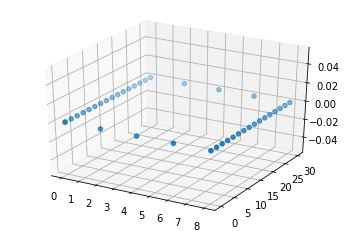

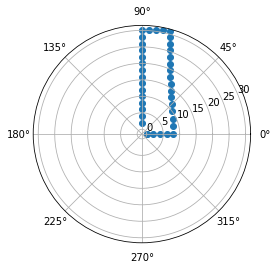

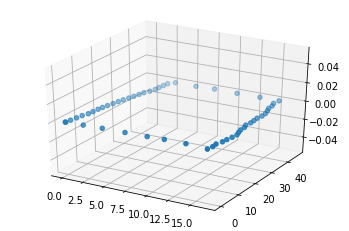

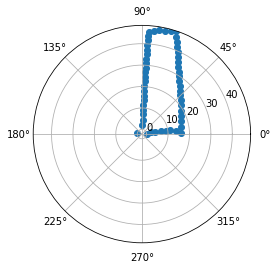

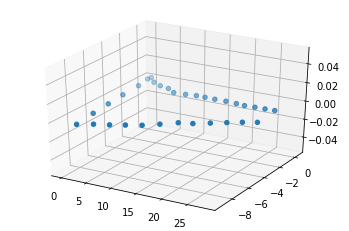

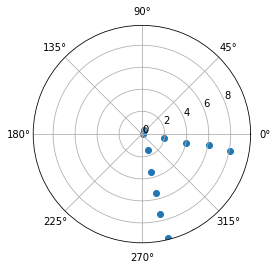

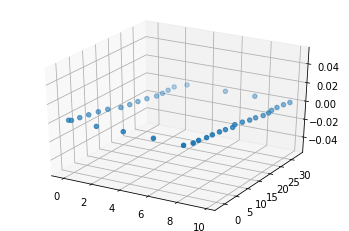

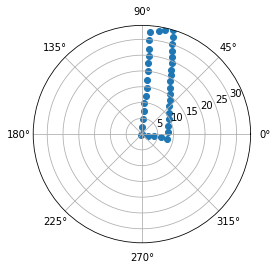

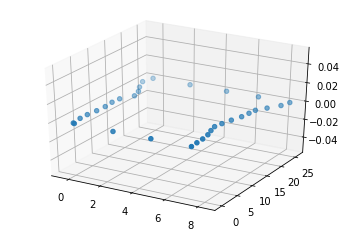

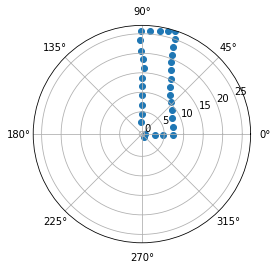

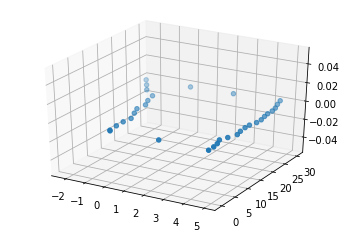

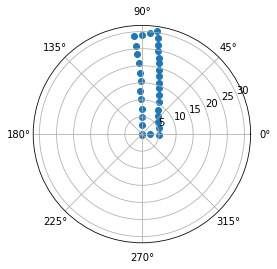

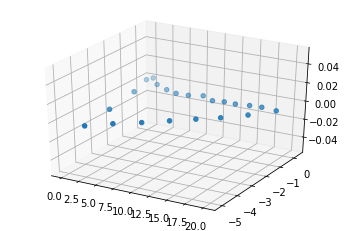

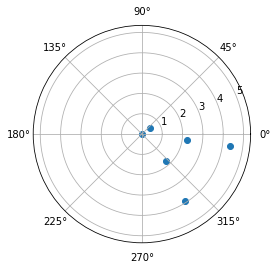

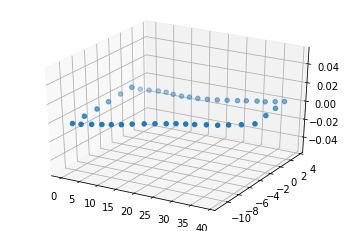

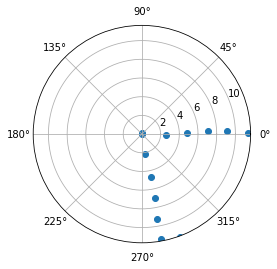

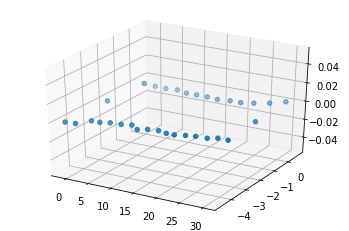

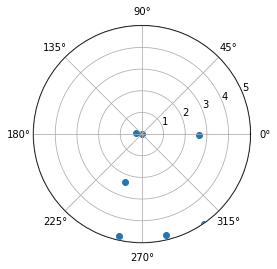

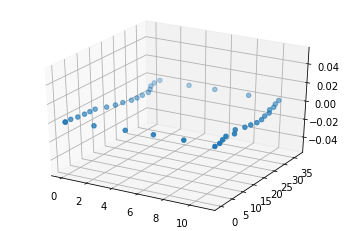

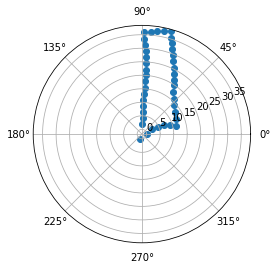

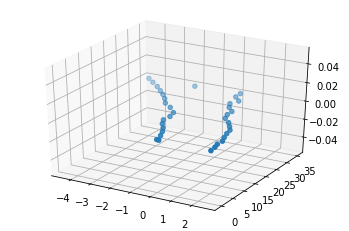

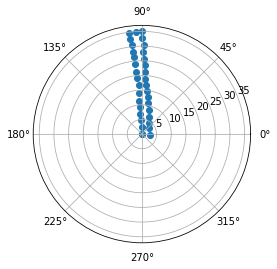

In [730]:
visualise(exp1GT)
i = 1 
totalmean = [0]
while i < 11:
    iphone_square = iphone_imu_read('IMU/iphone/Chest'+str(i)+'.csv')
    res = algorithm2(iphone_square)
    print(res)
    if res['mean'] < 10:
        totalmean.append(res['mean'])
    i = i + 1
tmean = sum(totalmean)/len(totalmean)
print('mean='+str(tmean))
print('percentage='+str(tmean*100/76)+'%')

### Intel T265 VSLAM

{'mean': 3.3394342632892946, 'peak': 8.987347518643363, 'stdev': 2.8082158181175236}
{'mean': 3.269256164543491, 'peak': 6.755190071726036, 'stdev': 1.5571276015492914}
{'mean': 3.7074910480340977, 'peak': 5.952243544355776, 'stdev': 1.2117417201107858}
{'mean': 3.9404802016341707, 'peak': 5.836948526765247, 'stdev': 1.5557711223361894}
{'mean': 3.558507188149956, 'peak': 6.263013878618264, 'stdev': 1.4929999070292872}


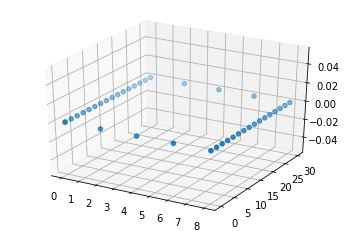

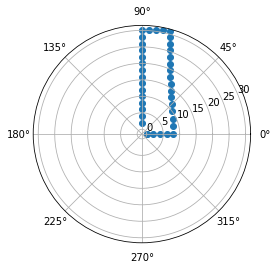

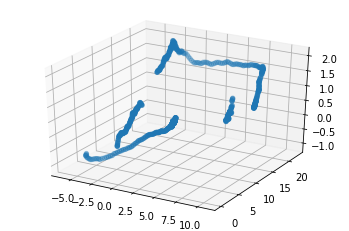

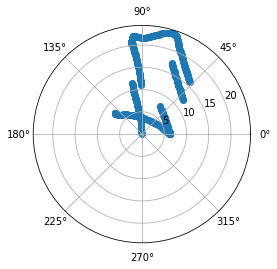

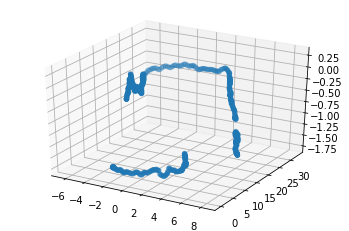

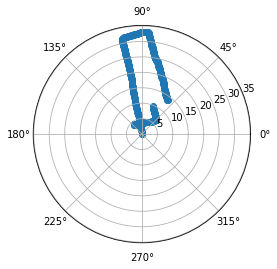

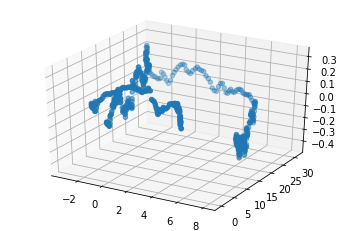

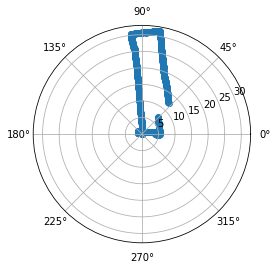

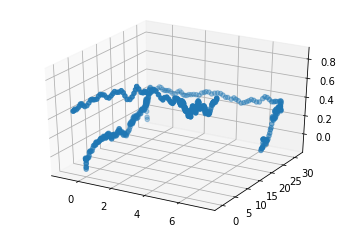

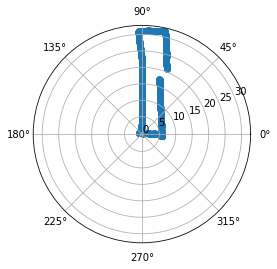

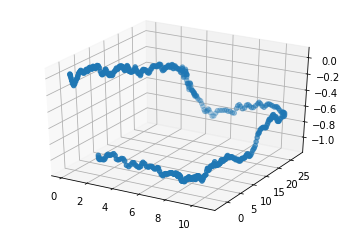

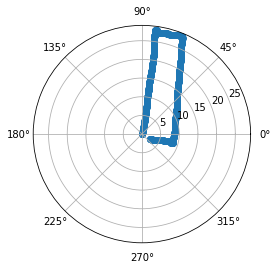

In [640]:
data = intel_read('VSLAM/intel/indoorlog.csv')
datasquares = intel_read('VSLAM/intel/ecp.csv')
for i in range(0, len(datasquares)-1):
    datasquares.loc[i, 'timegap'] = datasquares.loc[i+1, 'time'] - datasquares.loc[i, 'time']  
datasquares.timegap = pd.to_timedelta(datasquares.timegap)
g = datasquares.groupby((datasquares.timegap / pd.Timedelta('1 second')).ge(1)[::-1].cumsum())
listofdf = {}
for n,g in g:
    if len(g) > 500:
        g = g.reset_index()
        g['positionX'] = g['positionX']*-1.3
        g['positionZ'] = g['positionZ']*-1.3
        listofdf[n] = g
    
def visualise(ind):
    startx = ind['positionX'][0]
    starty = ind['positionY'][0]
    startz = ind['positionZ'][0]
    ind['normalisedX'] = ind['positionX'].apply(lambda x: x-startx)
    ind['normalisedY'] = ind['positionY'].apply(lambda x: x-starty)
    ind['normalisedZ'] = ind['positionZ'].apply(lambda x: x-startz)
    visualisation(ind['normalisedZ'],ind['normalisedX'],ind['normalisedY'])

# visualise(data)
visualise(exp1GT)
for exp in listofdf.values():
    visualise(exp)
    print(error(exp1GT, exp))

### Apple ArKit VSLAM

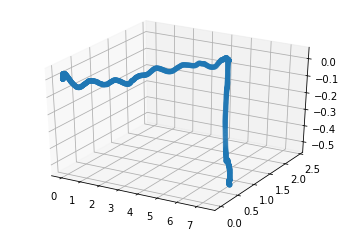

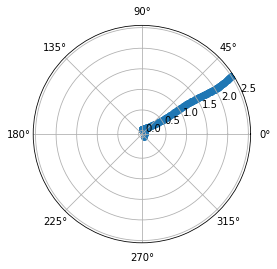

In [533]:
ip_ar = iphone_camera_read('VSLAM/apple/indoorlog.csv')
startx = ip_ar.iloc[[0],[4]].values[0][0]
starty = ip_ar.iloc[[0],[8]].values[0][0]
startz = ip_ar.iloc[[0],[12]].values[0][0]
ip_ar['normalisedX'] = ip_ar['positionX'].apply(lambda x: x-startx)
ip_ar['normalisedY'] = ip_ar['positionY'].apply(lambda x: x-starty)
ip_ar['normalisedZ'] = ip_ar['positionZ'].apply(lambda x: x-startz)
plot(ip_ar['normalisedZ'],ip_ar['normalisedX'],ip_ar['normalisedY'])